## 1. Load CSV
## 2. Create hidden df (80/20)
## 3. Retrieve lists of good/bad main-url.com (+2 feat)
## 4. Retrieve lists of good/bad mentions.    (+2 feat)
## 5. Retrieve lists of good/bad hashtags.    (+2 feat)
## 6. Create auxiliar functions
## 7. Create preProcessing(df): function
## 8. Drop 'id' and 'title'                   (-2 feat)
## 9. Perform feature importance
##10. Perform sentiment analysis              (+1 feat)
##11. Perform emotion analysis                (+5 feat)
##12. Drop all textual features               (-4 feat)


In [148]:
# SETUP
!pip install text2emotion
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('vader_lexicon')

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import math
import text2emotion as te
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [149]:
url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/tweets.csv'
df = pd.read_csv(url)

tweets, hidden = train_test_split(df, test_size=0.2, random_state = 1)

true_tweets = tweets.loc[tweets['questionable_domain'] == 0]
fake_tweets = tweets.loc[tweets['questionable_domain'] == 1]

# URLs

In [56]:
from urllib.parse import urlparse
import re
import requests

def searchUrl(tweet):
  ans = re.search("(?P<url>https?://[^\s]+)",tweet).group("url")
  return ans

def convertDomain(url):
  if url != '':
    resp = requests.head(url)
    resp.status_code
    if 'Location' in resp.headers:
      long_link = resp.headers['Location']
      parsed_uri = urlparse(long_link)  # returns six components
      domain = '{uri.netloc}/'.format(uri=parsed_uri)
      return domain[:-1]
    else:
      return ''
  else:
    return url


The following cell will take about 17 minutes to run.
THIS CANNOT BE "FAST-FORWARD"

In [57]:
tu = list(true_tweets['description'].apply(searchUrl))
fu = list(fake_tweets['description'].apply(searchUrl))

tu = [convertDomain(url) for url in tu]
fu = [convertDomain(url) for url in fu]

In [58]:
tu = [link.replace('www.','') for link in tu]
fu = [link.replace('www.','') for link in fu]

#print(tu)
#print(len(tu))
#print(fu)
#print(len(fu))

# We will check if there is any URL in common
to_delete = list(set(tu).intersection(fu))
#print(to_delete)

good_urls = tu
bad_urls = fu

for link in good_urls:
  if link in to_delete:
    good_urls.remove(link)

for link in bad_urls:
  if link in to_delete:
    bad_urls.remove(link)

# Hashtags

In [59]:
def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

true_hashtags = list(true_tweets['description'].apply(getHashtags))
for hash in true_hashtags:
  if hash == []:
    true_hashtags.remove(hash)
true_hashtags = [item for sublist in true_hashtags for item in sublist]
# Put all in lowercase
thl=[]
for hash in true_hashtags:
  thl.append(hash.lower())


fake_hashtags = list(fake_tweets['description'].apply(getHashtags))
for hash in fake_hashtags:
  if hash == []:
    fake_hashtags.remove(hash)
fake_hashtags = [item for sublist in fake_hashtags for item in sublist]
# Put all in lowercase
fhl=[]
for hash in fake_hashtags:
  fhl.append(hash.lower())


# FAKE
data = {"hashs": fhl}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')

# TRUE
data = {"hashs": thl}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')

# ALL
all_hashtags_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_hashtags_df['counts_true'] = all_hashtags_df['counts_true'].fillna(0)
all_hashtags_df['counts_fake'] = all_hashtags_df['counts_fake'].fillna(0)

lf = []
for i in range(len(all_hashtags_df)):
  value = all_hashtags_df['counts_fake'][i] / (all_hashtags_df['counts_fake'][i]+all_hashtags_df['counts_true'][i])
  lf.append(value)

all_hashtags_df['hashtags_fake_percentage'] = lf

lt = []
for i in range(len(all_hashtags_df)):
  value = all_hashtags_df['counts_true'][i] / (all_hashtags_df['counts_fake'][i]+all_hashtags_df['counts_true'][i])
  lt.append(value)

all_hashtags_df['hashtags_true_percentage'] = lt


#print(all_hashtags_df.loc[all_hashtags_df['counts_fake'] >= 5].sort_values(by=["hashtags_fake_percentage","counts_fake"],ascending=False)[:15])
#print(all_hashtags_df.loc[all_hashtags_df['counts_true'] >= 25].sort_values(by=["hashtags_true_percentage","counts_true"],ascending=False)[:])


interesting_hashs_1 = all_hashtags_df.loc[(all_hashtags_df['counts_fake'] >= 5) & (all_hashtags_df['hashtags_fake_percentage'] >=0.90)]
fake_hash_list = list(interesting_hashs_1['unique_values'])
#print(fake_hash_list)


interesting_hashs_2 = all_hashtags_df.loc[(all_hashtags_df['counts_true'] >= 25) & (all_hashtags_df['hashtags_true_percentage'] >=0.90)]
true_hash_list = list(interesting_hashs_2['unique_values'])
#print(true_hash_list)




######
###### Analise dos Hashtags count
######

def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

my_fake_tweets = fake_tweets[:]
my_true_tweets = true_tweets[:]

# Creating a new column of mentions of that tweet
my_fake_tweets['hashtags'] = my_fake_tweets['description'].apply(getHashtags)
my_fake_tweets['hashtags_count'] = my_fake_tweets['hashtags'].apply(len)
my_fake_tweets = list(my_fake_tweets.hashtags_count)

my_true_tweets['hashtags'] = my_true_tweets['description'].apply(getHashtags)
my_true_tweets['hashtags_count'] = my_true_tweets['hashtags'].apply(len)
my_true_tweets = list(my_true_tweets.hashtags_count)


hashLen_dic = {"hashLen_true":my_true_tweets,"hashLen_fake":my_fake_tweets}

fig, ax = plt.subplots()
ax.boxplot(hashLen_dic.values())
ax.set_xticklabels(hashLen_dic.keys())

print(DataFrame(my_fake_tweets,columns=["hashLen_fake"]).describe())
print(DataFrame(my_true_tweets,columns=["hashLen_true"]).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

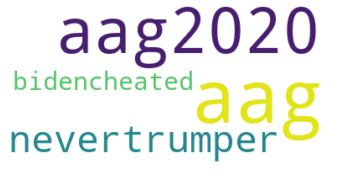

In [60]:
words_for_cloud = ' '.join(fake_hash_list)

fake_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

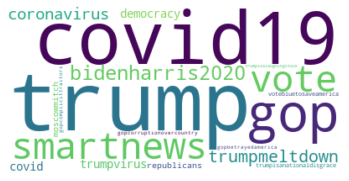

In [61]:
words_for_cloud = ' '.join(true_hash_list)

true_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Mentions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

       mentLen_fake
count   2407.000000
mean       2.448276
std        5.624334
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       50.000000
       mentLen_true
count  11953.000000
mean       2.461558
std        4.704794
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       50.000000


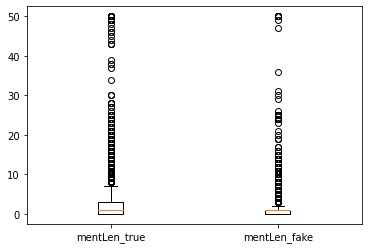

In [65]:
def getMentions(tweet):
  res = []
  ans = re.findall("(^|[^@\w])@(\w{1,15})", tweet)
  for item in ans:
    res.append(item[1])
  return res

true_mentions = list(true_tweets['description'].apply(getMentions))
for mention in true_mentions:
  if mention == []:
    true_mentions.remove(mention)
true_mentions = [item for sublist in true_mentions for item in sublist]
# Put all in lowercase
tml=[]
for mention in true_mentions:
  tml.append(mention.lower())


fake_mentions = list(fake_tweets['description'].apply(getMentions))
for mention in fake_mentions:
  if mention == []:
    fake_mentions.remove(mention)
fake_mentions = [item for sublist in fake_mentions for item in sublist]
# Put all in lowercase
fml=[]
for mention in fake_mentions:
  fml.append(mention.lower())


# FAKE
data = {"mentions": fml}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')

# TRUE
data = {"mentions": tml}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')

# ALL
all_mentions_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_mentions_df['counts_fake'] = all_mentions_df['counts_fake'].fillna(0)
all_mentions_df['counts_true'] = all_mentions_df['counts_true'].fillna(0)


lf = []
for i in range(len(all_mentions_df)):
  value = all_mentions_df['counts_fake'][i] / (all_mentions_df['counts_fake'][i]+all_mentions_df['counts_true'][i])
  lf.append(value)

all_mentions_df['mentions_fake_percentage'] = lf


lt = []
for i in range(len(all_mentions_df)):
  value = all_mentions_df['counts_true'][i] / (all_mentions_df['counts_fake'][i]+all_mentions_df['counts_true'][i])
  lt.append(value)

all_mentions_df['mentions_true_percentage'] = lt


#print(all_mentions_df.loc[all_mentions_df['counts_fake'] >= 25].sort_values(by=["mentions_fake_percentage","counts_fake"],ascending=False)[:20])
#print(all_mentions_df.loc[all_mentions_df['counts_true'] >= 150].sort_values(by=["mentions_true_percentage","counts_true"],ascending=False)[:20])


interesting_mentions_1 = all_mentions_df.loc[(all_mentions_df['counts_fake'] >= 25) & (all_mentions_df['mentions_fake_percentage'] >=0.90)]
fake_mention_list = list(interesting_mentions_1['unique_values'])
#print(fake_mention_list)

interesting_mentions_2 = all_mentions_df.loc[(all_mentions_df['counts_true'] >= 150) & (all_mentions_df['mentions_true_percentage'] >=0.90)]
true_mention_list = list(interesting_mentions_2['unique_values'])
#print(true_mention_list)




#####
#####. Analise dos Mentions count
#####

my_fake_tweets = fake_tweets[:]
my_true_tweets = true_tweets[:]

# Creating a new column of mentions of that tweet
my_fake_tweets['mentions'] = my_fake_tweets['description'].apply(getMentions)
my_fake_tweets['mentions_count'] = my_fake_tweets['mentions'].apply(len)
my_fake_tweets = list(my_fake_tweets.mentions_count)

my_true_tweets['mentions'] = my_true_tweets['description'].apply(getMentions)
my_true_tweets['mentions_count'] = my_true_tweets['mentions'].apply(len)
my_true_tweets = list(my_true_tweets.mentions_count)


mentLen_dic = {"mentLen_true":my_true_tweets,"mentLen_fake":my_fake_tweets}

fig, ax = plt.subplots()
ax.boxplot(mentLen_dic.values())
ax.set_xticklabels(mentLen_dic.keys())

fmdf = pd.DataFrame(my_fake_tweets,columns=["mentLen_fake"])
print(fmdf.describe())
tmdf = pd.DataFrame(my_true_tweets,columns=["mentLen_true"])
print(tmdf.describe())

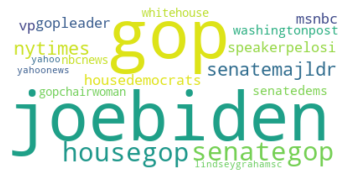

In [66]:
words_for_cloud = ' '.join(true_mention_list)

true_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

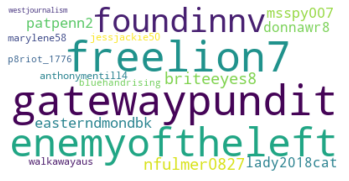

In [67]:
words_for_cloud = ' '.join(fake_mention_list)

fake_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Words

In [68]:
####### Prepare text functions #########

def capsCount(tweet):
  tw = removePonctuation(tweet)
  tw = lemmatizeSentence(tw)
  tw = tw.split(" ")
  tw = [i for i in tw if i.isupper()]
  return len(tw)

# removes ponctuation from a text 
def removePonctuation(text):
  ans = re.sub(r'[^\w\s]', '', text)
  return ans

def removeUrl(tweet):
  ans = re.sub(r'http\S+', '', tweet)
  return ans

def removeMentions(tweet):
  ans = re.sub(r'@\S+', '', tweet)
  return ans

def removeHashtags(tweet):
  ans = re.sub(r'#\S+', '', tweet)
  return ans

# removes Stop Words
def removeStopWords(text):
  text_tokens = nltk.tokenize.word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in nltk.corpus.stopwords.words()]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence


lemmatizer = WordNetLemmatizer()
def getWordnetPOS(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizeSentence(text):
  ans = [lemmatizer.lemmatize(w, getWordnetPOS(w)) for w in nltk.word_tokenize(text)]
  lemmatized_output = ' '.join(ans)
  return lemmatized_output

In [69]:
# Let's proceed to an analysis of the most used words in these tweets

fake_description = fake_tweets['description']
fake_description_list = list(fake_description)

A = ' '.join(fake_description_list)
A = removeUrl(A)
A = removeMentions(A)
A = removeHashtags(A)
A = removePonctuation(A)
A = removeStopWords(A)
A = lemmatizeSentence(A)
A = A.split(' ')

data = {"words": A}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')


true_description = true_tweets['description']
true_description_list = list(true_description)

B = ' '.join(true_description_list)
B = removeUrl(B)
B = removeMentions(B)
B = removeHashtags(B)
B = removePonctuation(B)
B = removeStopWords(B)
B = lemmatizeSentence(B)
B = B.split(' ')

data = {"words": B}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')
true_df


all_description_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_description_df

lf = []
for i in range(len(all_description_df)):
  value = all_description_df['counts_fake'][i] / (all_description_df['counts_fake'][i]+all_description_df['counts_true'][i])
  lf.append(value)

all_description_df['word_fake_percentage'] = lf

all_description_df['word_fake_percentage'] = all_description_df['word_fake_percentage'].fillna(0)
all_description_df['counts_fake'] = all_description_df['counts_fake'].fillna(0)


lt = []
for i in range(len(all_description_df)):
  value = all_description_df['counts_true'][i] / (all_description_df['counts_fake'][i]+all_description_df['counts_true'][i])
  lt.append(value)

all_description_df['word_true_percentage'] = lt
all_description_df['word_true_percentage'] = all_description_df['word_true_percentage'].fillna(0)
all_description_df['counts_true'] = all_description_df['counts_true'].fillna(0)


interesting_words_1 = all_description_df.loc[all_description_df['word_fake_percentage'] >= 0.90]
iw_1 = list(interesting_words_1['unique_values'])


interesting_words_2 = all_description_df.loc[(all_description_df['counts_true'] >= 200) & (all_description_df['word_true_percentage'] >=0.9)]
iw_2 = list(interesting_words_2['unique_values'])

interesting_words = iw_1+iw_2

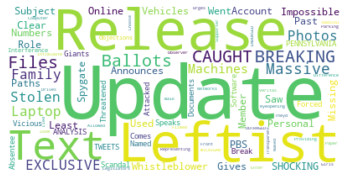

In [70]:
words_for_cloud = ' '.join(iw_1)

fake_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

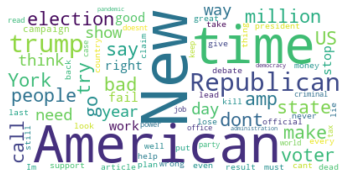

In [71]:
words_for_cloud = ' '.join(iw_2)

true_word_cloud = WordCloud(background_color='white').generate(words_for_cloud)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Box-plot

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[Text(0, 0, 'w_true'), Text(0, 0, 'w_fake')]

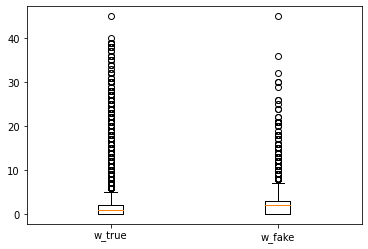

In [150]:
w_fake = [i.split(" ") for i in fake_description_list]
w_fake2 = []
for i in w_fake:
  w_fake2.append([removePonctuation(j) for j in i])
w_fake = []
for i in w_fake2:
  w_fake.append([lemmatizeSentence(j) for j in i])


w1 = []
for i in w_fake:
  w1.append(len([j for j in i if j.isupper()]))


w_true = [i.split(" ") for i in true_description_list]
w_true2 = []
for i in w_true:
  w_true2.append([removePonctuation(j) for j in i])
w_true = []
for i in w_true2:
  w_true.append([lemmatizeSentence(j) for j in i])


w2 = []
for i in w_true:
  w2.append(len([j for j in i if j.isupper()]))


caps_dic = {"w_true":w2,"w_fake":w1}

fig, ax = plt.subplots()
ax.boxplot(caps_dic.values())
ax.set_xticklabels(caps_dic.keys())

#print(DataFrame(w1,columns=["w_fake"]).describe())
#print(DataFrame(w2,columns=["w_true"]).describe())


# Pre-processing

In [151]:
############ Auxiliar Functions #############
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import text2emotion as te

def capsCount(tweet):
  tw = removePonctuation(tweet)
  tw = lemmatizeSentence(tw)
  tw = tw.split(" ")
  tw = [i for i in tw if i.isupper()]
  return len(tw)

def gatewaypunditInTweet(mentions_list):
  if "gatewaypundit" in mentions_list:
    return 1
  return 0

# counts how many words a string has
def countWord(string):
  s = string.split(' ')
  return len(s)

# removes a URL from a string
def removeUrl(tweet):
  ans = re.sub(r'http\S+', '', tweet)
  return ans

# gives us a list of @mentions
def getMentions(tweet):
  res = []
  ans = re.findall("(^|[^@\w])@(\w{1,15})", tweet)
  for item in ans:
    res.append(item[1])
  return res

# gets list of #wordtags
def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

# converts bool to 0/1
def boolToBinary(value):
  if value == False:
    return 0
  else:
    return 1

# checks if url is in bad_urls list
def containsBadURLs(url):
  if url in bad_urls:
    return 1
  else:
    return 0

# checks if url is in good_urls list
def containsGoodURLs(url):
  if url in good_urls:
    return 1
  else:
    return 0

# checks if mention is in fake_mention_list
def containsBadMentions(mentions_list):
  for mention in mentions_list:
    if mention in fake_mention_list:
      return 1
  return 0

# checks if mention is in true_mention_list
def containsGoodMentions(mentions_list):
  for mention in mentions_list:
    if mention in true_mention_list:
      return 1
  return 0

# checks if hash is in fake_hash_list
def containsBadHashtags(hashtags_list):
  for hash in hashtags_list:
    if hash in fake_hash_list:
      return 1
  return 0

# checks if hash is in true_hash_list
def containsGoodHashtags(hashtags_list):
  for hash in hashtags_list:
    if hash in true_hash_list:
      return 1
  return 0

# checks if word is in fake_word_list
def containsBadWords(words_list):
  for word in words_list:
    if word in iw_1:
      return 1
  return 0

# checks if word is in true_word_list
def containsGoodWords(words_list):
  for word in words_list:
    if word in iw_2:
      return 1
  return 0


sia = SentimentIntensityAnalyzer()
def sentimentAnalysis(text):
  return sia.polarity_scores(text)["compound"]


def getAngryLevel(text):
  return te.get_emotion(text)['Angry']

def getFearLevel(text):
  return te.get_emotion(text)['Fear']

def getHappyLevel(text):
  return te.get_emotion(text)['Happy']

def getSadLevel(text):
  return te.get_emotion(text)['Sad']

def getSurpriseLevel(text):
  return te.get_emotion(text)['Surprise']


In [153]:
def preProcessing(df):

  # Removing unecessary features
  df = df.drop(['id','title'], axis=1)

  # Creating a new column name taht gives us the number of words in a tweet
  df['word_count'] = df['description'].apply(countWord)

  # Creating new column 'url'
  df['url'] = df['description'].apply(searchUrl)
  df['url'] = df['url'].apply(convertDomain)

  # Updating 'description' column
  df['description'] = df['description'].apply(removeUrl)

  # Creating a new column of mentions of that tweet
  df['mentions'] = df['description'].apply(getMentions)
  df['contains_gatewaypundit'] = df['mentions'].apply(gatewaypunditInTweet)

  # Creating a new column of hashtags of that tweet
  df['hashtags'] = df['description'].apply(getHashtags)

  df['mentions_count'] = df['mentions'].apply(len)

  df['hashtags_count'] = df['hashtags'].apply(len)

  df['Caps_count'] = df['description'].apply(capsCount)

  # Switching 'False' for 0 and 'True' for 1
  df['contains_profanity'] = df['contains_profanity'].apply(boolToBinary)
  df['questionable_domain'] = df['questionable_domain'].apply(boolToBinary)
  df['user_verified'] = df['user_verified'].apply(boolToBinary)


  df['contains_bad_url'] = df['url'].apply(containsBadURLs)
  df['contains_good_url'] = df['url'].apply(containsGoodURLs)

  df['contains_bad_mentions'] = df['mentions'].apply(containsBadMentions)
  df['contains_good_mentions'] = df['mentions'].apply(containsGoodMentions)

  df['contains_bad_hashtags'] = df['hashtags'].apply(containsBadHashtags)
  df['contains_good_hashtags'] = df['hashtags'].apply(containsGoodHashtags)


  ##### Taking care of the text #####

  # Removing ponctuation from 'description'
  df['description'] = df['description'].apply(removePonctuation)

  # Puting everything lowercase
  df['description'] = df['description'].apply(str.lower)

  # Removing StopWords
  df['description'] = df['description'].apply(removeStopWords)

  # Doing Lemmatization
  df['description'] = df['description'].apply(lemmatizeSentence)

  # Sentiment Analysis
  df['sentiment_analysis'] = df['description'].apply(sentimentAnalysis)

  df['contains_bad_words'] = df['description'].apply(containsBadWords)
  df['contains_good_words'] = df['description'].apply(containsGoodWords)

  df['angry_level'] = df['description'].apply(getAngryLevel)

  df['fear_level'] = df['description'].apply(getFearLevel)

  df['happy_level'] = df['description'].apply(getHappyLevel)

  df['sad_level'] = df['description'].apply(getSadLevel)

  df['surprise_level'] = df['description'].apply(getSurpriseLevel)


  df = df.drop(['url','mentions','description','hashtags'], axis = 1)

  return df

# Run the following cell
# DO NOT run the tweets = preProcessing(tweets) - it will take about 2 hours


In [152]:
url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/tweets_aposPP.csv'
tweets = pd.read_csv(url)
del tweets['Unnamed: 0']

In [ ]:
tweets = preProcessing(tweets)

# Feature Importance

In [154]:
from sklearn.ensemble import ExtraTreesClassifier

features_names = tweets.columns.values.tolist()
data = tweets

# Create Dependent and Independent Datasets based on our Dependent 
# feature (target)

X = data.loc[:, data.columns != 'questionable_domain']

y = data['questionable_domain']

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

importance_list = list(model.feature_importances_)


a = features_names[1:]
b = importance_list

c = zip(a,b)
c = list(c)

d = sorted(c, key = lambda x: x[1])
d

[('contains_bad_words', 0.0),
 ('contains_good_words', 0.0),
 ('contains_good_hashtags', 0.0005874699432232321),
 ('contains_bad_hashtags', 0.0016119854749253337),
 ('user_verified', 0.0029454291438241885),
 ('contains_profanity', 0.003755917796099953),
 ('contains_good_mentions', 0.005099686575435427),
 ('contains_good_url', 0.010976088244541021),
 ('angry_level', 0.01241404328472607),
 ('happy_level', 0.015444158501069083),
 ('hashtags_count', 0.019820773020521217),
 ('sad_level', 0.023498972695814475),
 ('retweet_count', 0.02359863729372538),
 ('fear_level', 0.02510028166411792),
 ('favorite_count', 0.025863212973358685),
 ('surprise_level', 0.02861793415698033),
 ('mentions_count', 0.033559725864808744),
 ('Caps_count', 0.037188565630591815),
 ('user_favourites_count', 0.038934684182772024),
 ('sentiment_analysis', 0.04095641631308406),
 ('user_followers_count', 0.04274000870471974),
 ('word_count', 0.044796629128463314),
 ('user_friends_count', 0.04726876477239052),
 ('contains_ga

# Remove least important features

In [155]:
tweets = tweets.drop(['contains_good_hashtags','contains_bad_hashtags','contains_profanity','user_verified','contains_good_mentions','contains_good_words','contains_bad_words'], axis = 1)

# Initialize ML Algorithms

In [156]:
# let's check out models:

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# importing models
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost
import lightgbm as lgb

In [157]:
nb_classifier = GaussianNB()
rf_classifier = RandomForestClassifier(n_estimators=100)
adb_classifier = AdaBoostClassifier(n_estimators=100)
lgb_classifier = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
mlp_classifier = MLPClassifier(random_state=1, max_iter=300)
sgd_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=50)
knn3_classifier = KNeighborsClassifier(n_neighbors=3)
knn5_classifier = KNeighborsClassifier(n_neighbors=5)
knn7_classifier = KNeighborsClassifier(n_neighbors=7)
eclf1 = VotingClassifier(estimators=[('adb', adb_classifier), ('rf', rf_classifier), ('nb', nb_classifier)], voting='hard')


classifiers = [nb_classifier, rf_classifier, adb_classifier, mlp_classifier,
               sgd_classifier, knn3_classifier, knn5_classifier, knn7_classifier,
               lgb_classifier, eclf1]

In [158]:
data = tweets

# Create Dependent and Independent Datasets based on our Dependent 
# feature (target)

X = data.loc[:, data.columns != 'questionable_domain']

y = data['questionable_domain']


# We have imbalanced data, so we should perform under-sampling of the abundant 
# class, and perform over-sampling of the minority class

# Making 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train,y_train], axis = 1)
#check out how many fake and true cases we have:
print(train_df['questionable_domain'].value_counts())

0    8367
1    1685
Name: questionable_domain, dtype: int64


In [159]:
tt = tweets.loc[tweets['questionable_domain'] == 0]
ft = tweets.loc[tweets['questionable_domain'] == 1]

# Over-sampling:
q_subset = ft.sample(frac=0.5)
q_subset = pd.concat([q_subset, ft], axis=0)
len(q_subset)

3611

In [160]:
nq_subset = tt.sample(n=3611)

In [161]:
even_dataframe = pd.concat([nq_subset, q_subset])

# we should shuffle them in order to not have all 1s after 0s
even_dataframe = even_dataframe.sample(frac = 1, random_state = 1).reset_index()

del even_dataframe['index']

In [162]:
X_train = even_dataframe.loc[:, even_dataframe.columns != 'questionable_domain']

y_train = even_dataframe['questionable_domain']


for clf in classifiers:
  clf.fit(X_train,y_train)
  preds = clf.predict(X_test)

  print("with a single hold out:")
  print('{} accuracy:'.format(clf),metrics.accuracy_score(y_test, y_pred = preds))
  print('{} precision:'.format(clf),metrics.precision_score(y_test, y_pred = preds))
  print('{} recall:'.format(clf),metrics.recall_score(y_test, y_pred = preds))
  print('{} f1:'.format(clf),metrics.f1_score(y_test, y_pred = preds))

  scores = cross_val_score(clf, X, y, cv=10, scoring = 'accuracy')
  a1 = sum(list(scores))/10
  scores = cross_val_score(clf, X, y, cv=10, scoring = 'precision')
  a2 = sum(list(scores))/10
  scores = cross_val_score(clf, X, y, cv=10, scoring = 'recall')
  a3 = sum(list(scores))/10
  scores = cross_val_score(clf, X, y, cv=10, scoring = 'f1')
  a4 = sum(list(scores))/10

  print()

  print('With cross validation:')
  print('CV - {} accuracy:'.format(clf),a1)
  print('CV - {} precision:'.format(clf),a2)
  print('CV - {} recall:'.format(clf),a3)
  print('CV - {} f1:'.format(clf),a4)

  print()
  print()

with a single hold out:
GaussianNB() accuracy: 0.6253481894150418
GaussianNB() precision: 0.26175213675213677
GaussianNB() recall: 0.6786703601108033
GaussianNB() f1: 0.37779491133384735
[0.92916667 0.93333333 0.925      0.92116183 0.95435685 0.17427386
 0.93360996 0.96680498 0.94190871 0.93775934]

With cross validation:
CV - GaussianNB() accuracy: 0.2940807799442897
CV - GaussianNB() precision: 0.20566066802826516
CV - GaussianNB() recall: 0.8617375518672199
CV - GaussianNB() f1: 0.2879179754278332


with a single hold out:
RandomForestClassifier() accuracy: 0.9777158774373259
RandomForestClassifier() precision: 0.882640586797066
RandomForestClassifier() recall: 1.0
RandomForestClassifier() f1: 0.9376623376623378
[0.625      0.65416667 0.63333333 0.60580913 0.65975104 0.61825726
 0.60580913 0.63485477 0.56431535 0.66804979]

With cross validation:
CV - RandomForestClassifier() accuracy: 0.9357242339832869
CV - RandomForestClassifier() precision: 0.9824550316447702
CV - RandomForestCl

# Driver Code

In [ ]:
# Put in the following url variable the link/url of the csv to test

#url='<put_url_here>'


# Uncomment the following line,   B U T   COMMENT the next line

#data = pd.read_csv(url)
data = hidden

data = preProcessing(data)

In [124]:
hidden_after_preProcessing = data

In [125]:
from google.colab import files
hidden_after_preProcessing.to_csv('hidden_afterPP.csv', encoding = 'utf-8-sig') 
files.download('hidden_afterPP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [164]:
url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/hidden_afterPP.csv'
hidden_after_preProcessing = pd.read_csv(url)
del hidden_after_preProcessing['Unnamed: 0']

In [165]:
hidden_after_preProcessing = hidden_after_preProcessing.drop(['contains_good_hashtags','contains_bad_hashtags','contains_profanity','user_verified','contains_good_mentions','contains_good_words','contains_bad_words'], axis = 1)

In [166]:
X = hidden_after_preProcessing.loc[:, hidden_after_preProcessing.columns != 'questionable_domain']

y = hidden_after_preProcessing['questionable_domain']

print("################################# RESULTS OF MODELS USING HIDDEN #################################")
print()

rf_preds = rf_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(rf_classifier),metrics.accuracy_score(y, y_pred = rf_preds))
print('{} precision:'.format(rf_classifier),metrics.precision_score(y, y_pred = rf_preds))
print('{} recall:'.format(rf_classifier),metrics.recall_score(y, y_pred = rf_preds))
print('{} f1:'.format(rf_classifier),metrics.f1_score(y, y_pred = rf_preds))
print()

adb_preds = adb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(adb_classifier),metrics.accuracy_score(y, y_pred = adb_preds))
print('{} precision:'.format(adb_classifier),metrics.precision_score(y, y_pred = adb_preds))
print('{} recall:'.format(adb_classifier),metrics.recall_score(y, y_pred = adb_preds))
print('{} f1:'.format(adb_classifier),metrics.f1_score(y, y_pred = adb_preds))
print()

lgb_preds = lgb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(lgb_classifier),metrics.accuracy_score(y, y_pred = lgb_preds))
print('{} precision:'.format(lgb_classifier),metrics.precision_score(y, y_pred = lgb_preds))
print('{} recall:'.format(lgb_classifier),metrics.recall_score(y, y_pred = lgb_preds))
print('{} f1:'.format(lgb_classifier),metrics.f1_score(y, y_pred = lgb_preds))
print()

nb_preds = nb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(nb_classifier),metrics.accuracy_score(y, y_pred = nb_preds))
print('{} precision:'.format(nb_classifier),metrics.precision_score(y, y_pred = nb_preds))
print('{} recall:'.format(nb_classifier),metrics.recall_score(y, y_pred = nb_preds))
print('{} f1:'.format(nb_classifier),metrics.f1_score(y, y_pred = nb_preds))
print()

mlp_preds = mlp_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(mlp_classifier),metrics.accuracy_score(y, y_pred = mlp_preds))
print('{} precision:'.format(mlp_classifier),metrics.precision_score(y, y_pred = mlp_preds))
print('{} recall:'.format(mlp_classifier),metrics.recall_score(y, y_pred = mlp_preds))
print('{} f1:'.format(mlp_classifier),metrics.f1_score(y, y_pred = mlp_preds))
print()

sgd_preds = sgd_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(sgd_classifier),metrics.accuracy_score(y, y_pred = sgd_preds))
print('{} precision:'.format(sgd_classifier),metrics.precision_score(y, y_pred = sgd_preds))
print('{} recall:'.format(sgd_classifier),metrics.recall_score(y, y_pred = sgd_preds))
print('{} f1:'.format(sgd_classifier),metrics.f1_score(y, y_pred = sgd_preds))
print()

eclf1_preds = eclf1.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(eclf1),metrics.accuracy_score(y, y_pred = eclf1_preds))
print('{} precision:'.format(eclf1),metrics.precision_score(y, y_pred = eclf1_preds))
print('{} recall:'.format(eclf1),metrics.recall_score(y, y_pred = eclf1_preds))
print('{} f1:'.format(eclf1),metrics.f1_score(y, y_pred = eclf1_preds))
print()


################################# RESULTS OF MODELS USING HIDDEN #################################

with a single hold out:
RandomForestClassifier() accuracy: 0.9022284122562674
RandomForestClassifier() precision: 0.7184115523465704
RandomForestClassifier() recall: 0.6711635750421585
RandomForestClassifier() f1: 0.6939843068875327

with a single hold out:
AdaBoostClassifier(n_estimators=100) accuracy: 0.8646239554317549
AdaBoostClassifier(n_estimators=100) precision: 0.5733882030178327
AdaBoostClassifier(n_estimators=100) recall: 0.7048903878583473
AdaBoostClassifier(n_estimators=100) f1: 0.632375189107413

with a single hold out:
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) accuracy: 0.8916434540389973
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) precision: 0.6578947368421053
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) recall: 0.7166947723440135
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) f1: 0.68603

In [140]:
print("################################# RESULTS OF MODELS USING HIDDEN #################################")
print()

rf_preds = rf_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(rf_classifier),metrics.accuracy_score(y, y_pred = rf_preds))
print('{} precision:'.format(rf_classifier),metrics.precision_score(y, y_pred = rf_preds))
print('{} recall:'.format(rf_classifier),metrics.recall_score(y, y_pred = rf_preds))
print('{} f1:'.format(rf_classifier),metrics.f1_score(y, y_pred = rf_preds))
print()

adb_preds = adb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(adb_classifier),metrics.accuracy_score(y, y_pred = adb_preds))
print('{} precision:'.format(adb_classifier),metrics.precision_score(y, y_pred = adb_preds))
print('{} recall:'.format(adb_classifier),metrics.recall_score(y, y_pred = adb_preds))
print('{} f1:'.format(adb_classifier),metrics.f1_score(y, y_pred = adb_preds))
print()

lgb_preds = lgb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(lgb_classifier),metrics.accuracy_score(y, y_pred = lgb_preds))
print('{} precision:'.format(lgb_classifier),metrics.precision_score(y, y_pred = lgb_preds))
print('{} recall:'.format(lgb_classifier),metrics.recall_score(y, y_pred = lgb_preds))
print('{} f1:'.format(lgb_classifier),metrics.f1_score(y, y_pred = lgb_preds))
print()

nb_preds = nb_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(nb_classifier),metrics.accuracy_score(y, y_pred = nb_preds))
print('{} precision:'.format(nb_classifier),metrics.precision_score(y, y_pred = nb_preds))
print('{} recall:'.format(nb_classifier),metrics.recall_score(y, y_pred = nb_preds))
print('{} f1:'.format(nb_classifier),metrics.f1_score(y, y_pred = nb_preds))
print()

mlp_preds = mlp_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(mlp_classifier),metrics.accuracy_score(y, y_pred = mlp_preds))
print('{} precision:'.format(mlp_classifier),metrics.precision_score(y, y_pred = mlp_preds))
print('{} recall:'.format(mlp_classifier),metrics.recall_score(y, y_pred = mlp_preds))
print('{} f1:'.format(mlp_classifier),metrics.f1_score(y, y_pred = mlp_preds))
print()

sgd_preds = sgd_classifier.predict(X)
print("with a single hold out:")
print('{} accuracy:'.format(sgd_classifier),metrics.accuracy_score(y, y_pred = sgd_preds))
print('{} precision:'.format(sgd_classifier),metrics.precision_score(y, y_pred = sgd_preds))
print('{} recall:'.format(sgd_classifier),metrics.recall_score(y, y_pred = sgd_preds))
print('{} f1:'.format(sgd_classifier),metrics.f1_score(y, y_pred = sgd_preds))
print()



################################# RESULTS OF MODELS USING HIDDEN #################################

with a single hold out:
RandomForestClassifier() accuracy: 0.9050139275766017
RandomForestClassifier() precision: 0.725
RandomForestClassifier() recall: 0.684654300168634
RandomForestClassifier() f1: 0.7042497831743277

with a single hold out:
AdaBoostClassifier(n_estimators=100) accuracy: 0.8637883008356546
AdaBoostClassifier(n_estimators=100) precision: 0.5677083333333334
AdaBoostClassifier(n_estimators=100) recall: 0.7352445193929174
AdaBoostClassifier(n_estimators=100) f1: 0.6407053637031594

with a single hold out:
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) accuracy: 0.8852367688022285
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) precision: 0.6369137670196672
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) recall: 0.7099494097807757
LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42) f1: 0.671451355661882

w